In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import time
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch

import pickle

In [ ]:
""""
class BaselineCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super().__init__()
        self.input_shape = input_shape  # (C, H, W) format for PyTorch
        self.num_classes = num_classes
        
        # Conv layers with same padding (kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        
        # MaxPooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Dropout layers
        self.dropout = nn.Dropout(0.3)
        
        # Global Average Pooling equivalent
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Dense/Linear layers
        self.fc1 = nn.Linear(32, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # Conv + Pool blocks
        x = self.pool(F.relu(self.conv1(x)))      # 32 channels
        x = self.pool(F.relu(self.conv2(x)))      # 64 channels
        x = self.pool(F.relu(self.conv3(x)))      # 128 channels
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))      # 128 channels
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv5(x)))      # 64 channels
        x = self.pool(F.relu(self.conv6(x)))      # 32 channels
        
        # Global Average Pooling
        x = self.global_avg_pool(x)               # Shape: (batch, 32, 1, 1)
        x = x.view(x.size(0), -1)                 # Flatten: (batch, 32)
        
        # Dense layers
        x = F.relu(self.fc1(x))                   # 64 units
        x = self.fc2(x)                           # num_classes units
        
        return x
"""

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DeterministicCNNSingleFCTanh(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(F.tanh(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.tanh(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [3]:
def load_data(batch_size=64):  # Changed from 54 to 64 to match deterministic CNN
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3444, 0.3809, 0.4082], std=[0.1809, 0.1331, 0.1137])
    ])

    dataset = datasets.EuroSAT(root='./data', transform=transform, download=False)

    # Use fixed random seed for reproducible splits
    torch.manual_seed(42)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    #with open('datasplit/split_indices.pkl', 'rb') as f:
    #    split = pickle.load(f)
    #    train_dataset = Subset(dataset, split['train'])
    #    test_dataset = Subset(dataset, split['test'])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=4, pin_memory=True, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                            num_workers=4, pin_memory=True, persistent_workers=True)
    return train_loader, test_loader

In [4]:
# train the CNN model in 10 epoch
def train_cnn(model, train_loader, num_epochs=10):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    print("Training complete.")

# Evaluate the CNN model
def evaluate_cnn(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

In [ ]:
model_cnn = DeterministicCNNSingleFCTanh(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=100)
accuracy_tanh = evaluate_cnn(model_cnn, test_loader)

In [8]:
# print the model weights' and bias' mean and std for each layer, save it into a dict and print the dict

weight_stats = {}
for name, param in model_cnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        weight_stats[name] = {
            'mean': param.data.mean().item(),
            'std': param.data.std().item()
        }

In [9]:
weight_stats

{'conv1.weight': {'mean': -0.002307888586074114, 'std': 0.0991118773818016},
 'conv1.bias': {'mean': 0.005338362418115139, 'std': 0.22183896601200104},
 'conv2.weight': {'mean': -0.010187307372689247, 'std': 0.10347241908311844},
 'conv2.bias': {'mean': 0.02090350165963173, 'std': 0.18862959742546082},
 'fc1.weight': {'mean': -0.026102596893906593, 'std': 0.1766442358493805},
 'fc1.bias': {'mean': -0.015501600690186024, 'std': 0.17338263988494873}}

In [ ]:
for name, param in model_cnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        plt.figure(figsize=(10, 5))
        plt.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.7)
        plt.title(f'Histogram of {name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()

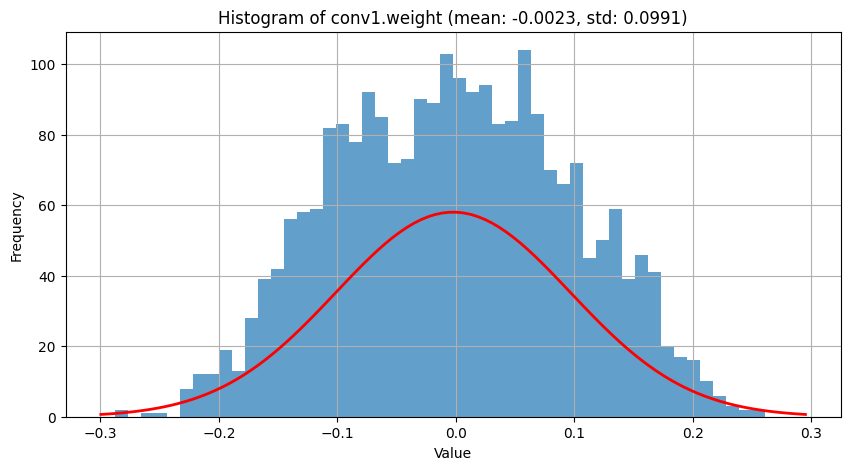

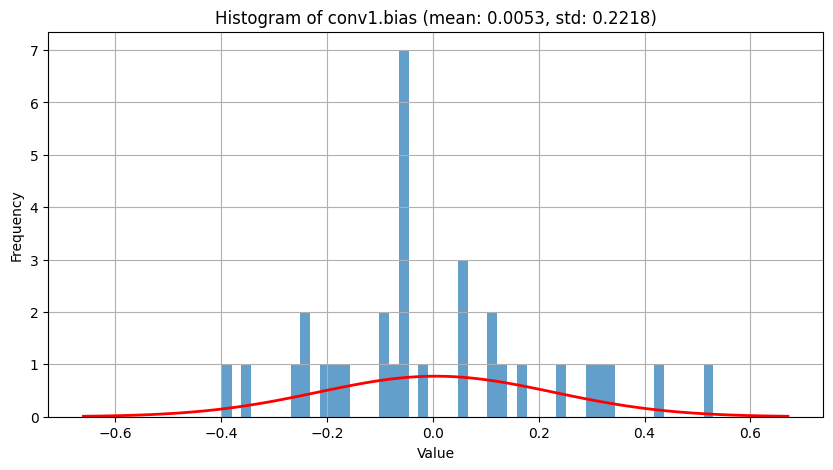

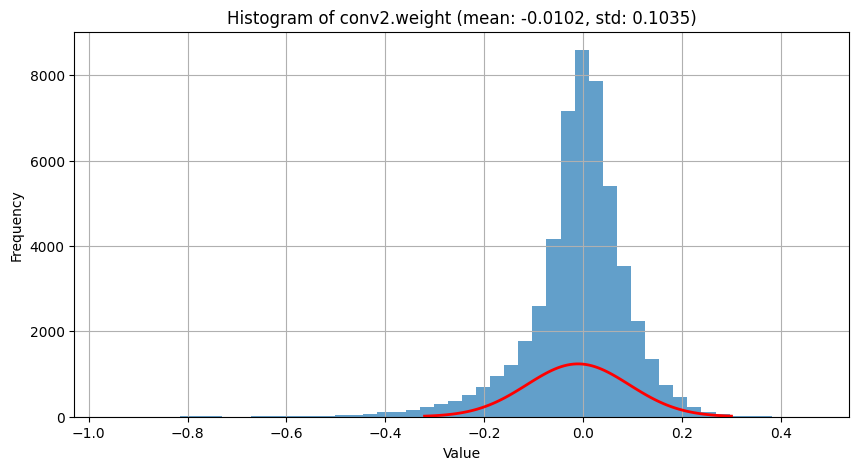

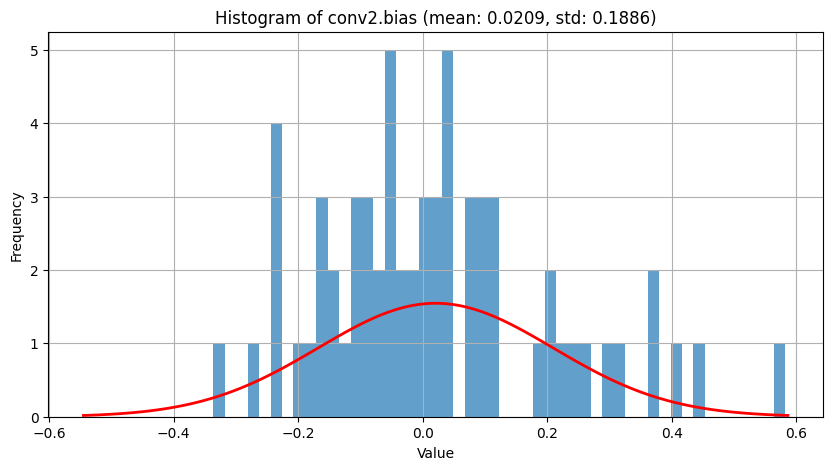

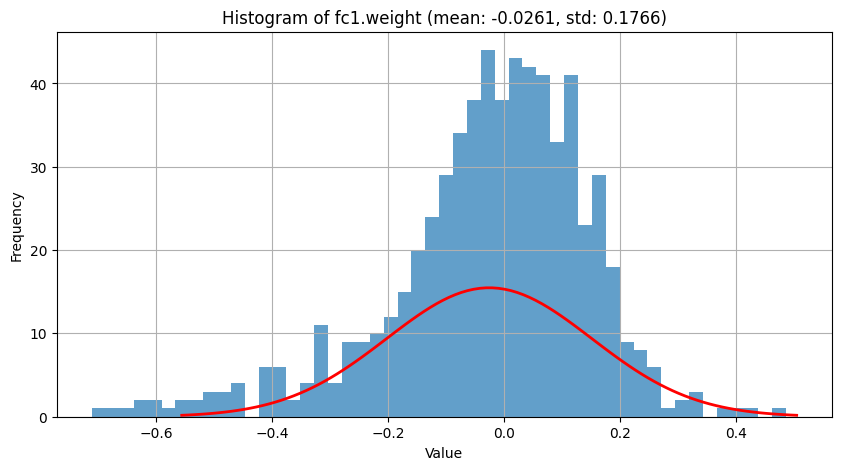

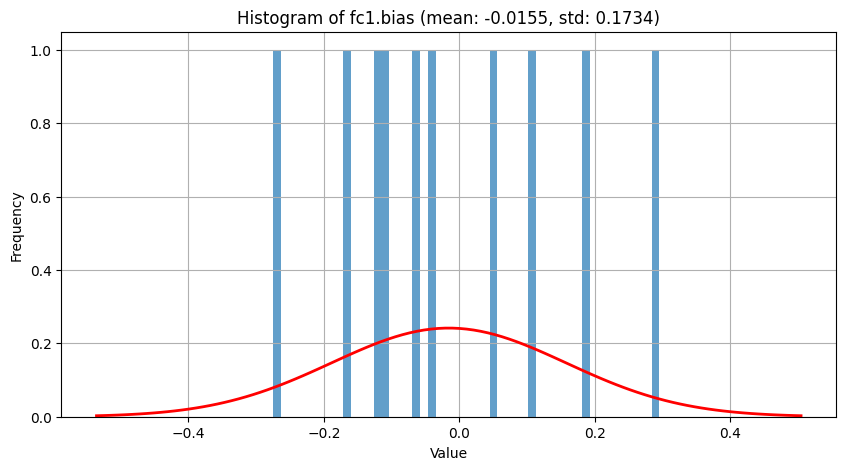

In [10]:
# plot the histogram of the weights and biases
# also show a line curve that shows normal distribution
import numpy as np

for name, param in model_cnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        plt.figure(figsize=(10, 5))
        plt.hist(param.data.cpu().numpy().flatten(), bins=50, alpha=0.7)
        # show normal distribution lines
        mean = weight_stats[name]['mean']
        std = weight_stats[name]['std']
        x = np.linspace(mean - 3*std, mean + 3*std, 100)
        normal_dist = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)
        plt.plot(x, normal_dist * len(param.data.cpu().numpy().flatten()) * (x[1] - x[0]), color='red', linewidth=2)
        # show mean and std lines
        #plt.axvline(weight_stats[name]['mean'], color='r', linestyle='dashed', linewidth=1)
        #plt.axvline(weight_stats[name]['mean'] + weight_stats[name]['std'], color='g', linestyle='dashed', linewidth=1)
        #plt.axvline(weight_stats[name]['mean'] - weight_stats[name]['std'], color='g', linestyle='dashed', linewidth=1)
        # add the title with mean and std in it
        plt.title(f'Histogram of {name} (mean: {weight_stats[name]["mean"]:.4f}, std: {weight_stats[name]["std"]:.4f})')
        #plt.title(f'Histogram of {name}')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.grid()
        plt.show()

In [11]:
# print all the weights and bias, without aggregating them
for name, param in model_cnn.named_parameters():
    if 'weight' in name or 'bias' in name:
        print(f"{name}: {param.data.cpu().numpy().flatten()}")

conv1.weight: [ 0.00893893  0.00415478  0.0576252  ... -0.17110495 -0.03613865
 -0.14389127]
conv1.bias: [ 0.17308429 -0.2608341  -0.17825572  0.25047553 -0.0620263  -0.05620621
 -0.08637676  0.43510488 -0.2463496   0.33288768 -0.3987936  -0.09816261
 -0.24505158  0.064041    0.12056161  0.5301498  -0.06376717  0.29286438
 -0.34784776 -0.05013644 -0.15793349 -0.20667204  0.04858182 -0.05306879
  0.11787578 -0.04857232 -0.08143237 -0.01059759 -0.04739991  0.05662915
  0.31144142  0.13661464]
conv2.weight: [ 0.0641295   0.0651432   0.05399366 ... -0.00989623 -0.0269688
 -0.03944238]
conv2.bias: [-0.05405794 -0.16714588 -0.01623695  0.03329084  0.0876953   0.2294313
 -0.03896579  0.07133206 -0.05425937 -0.06113121  0.04641254  0.11814832
 -0.2441924  -0.05535141  0.04474222  0.10426144 -0.12573439 -0.03736332
 -0.13554549  0.02481038  0.30708608  0.04846041 -0.10456817  0.03188924
 -0.20082605  0.18700437 -0.04857429  0.36729977  0.11332462 -0.09515046
 -0.15443279 -0.22801018  0.37899026

In [5]:
class DeterministicCNNSingleFCRelu(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(F.relu(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits

In [6]:
model_cnn = DeterministicCNNSingleFCRelu(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=10)
accuracy_relu = evaluate_cnn(model_cnn, test_loader)

Epoch [1/10], Loss: 1.1631
Epoch [2/10], Loss: 0.8054
Epoch [3/10], Loss: 0.6884
Epoch [4/10], Loss: 0.6317
Epoch [5/10], Loss: 0.5805
Epoch [6/10], Loss: 0.5523
Epoch [7/10], Loss: 0.5305
Epoch [8/10], Loss: 0.5027
Epoch [9/10], Loss: 0.4750
Epoch [10/10], Loss: 0.4559
Training complete.
Test Accuracy: 84.48%


In [ ]:
class DeterministicCNNSingleFCSigmoid(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(F.sigmoid(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(F.sigmoid(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits

In [ ]:
model_cnn = DeterministicCNNSingleFCSigmoid(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=100)
accuracy_sigmoid = evaluate_cnn(model_cnn, test_loader)

In [ ]:
class DeterministicCNNSingleFCSin(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(torch.sin(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(torch.sin(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits

In [ ]:
model_cnn = DeterministicCNNSingleFCSin(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=100)
accuracy_sin = evaluate_cnn(model_cnn, test_loader)

In [ ]:
class DeterministicCNNSingleFCWG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)
    
    def actWG(self, x, alpha=1.0):
        return x * torch.exp(-alpha * x**2)

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(self.actWG(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(self.actWG(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits

In [ ]:
model_cnn = DeterministicCNNSingleFCWG(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=100)
accuracy_WG = evaluate_cnn(model_cnn, test_loader)

In [ ]:
class DeterministicCNNSingleFCRWG(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.fc1 = nn.Linear(64, num_classes)
    
    def actRWG(self, x, alpha=1.0):
        return max(0,x * torch.exp(-alpha * x**2))

    def forward(self, x):
        # x: [B, 3, 64, 64]
        x = self.pool(self.actWG(self.conv1(x)))  # → [B, 32, 32, 32]
        x = self.pool(self.actWG(self.conv2(x)))  # → [B, 64, 16, 16]
        x = self.gap(x)                       # → [B, 64, 1, 1]
        x = x.view(x.size(0), -1)             # → [B, 64]
        logits = self.fc1(x)                  # → [B, num_classes]
        return logits

In [ ]:
model_cnn = DeterministicCNNSingleFCWG(num_classes=10).to(device)
train_loader, test_loader = load_data(batch_size=54)  # Use batch size of 64 for CNN
train_cnn(model_cnn, train_loader, num_epochs=100)
accuracy_rwg = evaluate_cnn(model_cnn, test_loader)

In [ ]:
#print all accuracies
print(f"Accuracy with Tanh activation: {accuracy_tanh:.2f}%")
print(f"Accuracy with ReLU activation: {accuracy_relu:.2f}%")
print(f"Accuracy with Sigmoid activation: {accuracy_sigmoid:.2f}%")
print(f"Accuracy with Sin activation: {accuracy_sin:.2f}%")
print(f"Accuracy with WG activation: {accuracy_WG:.2f}%")
print(f"Accuracy with RWG activation: {accuracy_rwg:.2f}%")